# Polya-Gamma sampler

For the reasons outlined in the previous notebook, we're abandoning the stick breaking process and doing something simpler. Well, conceptually simpler. Mathematically it's a bit more complicated.

I'm switching to a logistic mixture model, wherein topic weights for each document/monkey are drawn from a normal distribution and then squeezed through a softmax funtion to turn them into topic probabilities for each monkey. The complication is that the softmax function breaks conjugacy, which means you can't do Gibbs sampling. Or at least that was the case until [this paper](http://www.tandfonline.com/doi/abs/10.1080/01621459.2013.829001#.VwItGXUrJ5E) invented a new probability distribution that would allow for Gibbs sampling logistic normals.

Since it's not a commonly used probability distribution, the only publically available implementation is the author's R package. As we're not using R, I'll have to reimplement it myself in Julia.

The entire purpose of this notebook is to reassure myself that I wrote the sampler correctly. So I will be comparing draws from my sampler to draws piped in from their R implementation, both graphically and using Kolmogorov-Smirnoff tests. These will be offerred without comment because it is boring.

In [28]:
using HypothesisTests, StatsFuns, Gadfly, Colors, RCall
rcopy("library(BayesLogit)");
include("/home/seth/code/polyagamma/polygamma.jl");

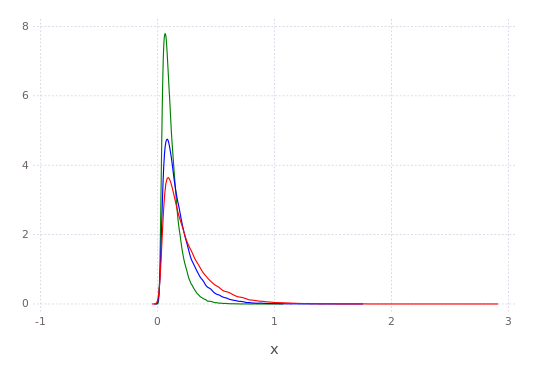

In [38]:
plot(layer(x=[rpolyagamma(0.0) for i = 1:1e5],Geom.density,Theme(default_color=colorant"red")),
layer(x=[rpolyagamma(2.0) for i = 1:1e5],Geom.density,Theme(default_color=colorant"blue")),
layer(x=[rpolyagamma(4.0) for i = 1:1e5],Geom.density,Theme(default_color=colorant"green")))

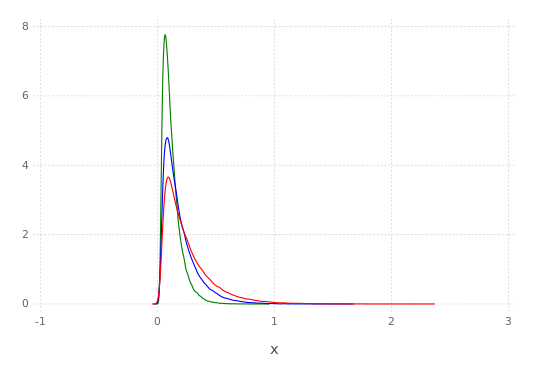

In [16]:
plot(layer(x=rcopy("rpg.devroye(1e5,z=0)"),Geom.density,Theme(default_color=colorant"red")),
layer(x=rcopy("rpg.devroye(1e5,z=2)"),Geom.density,Theme(default_color=colorant"blue")),
layer(x=rcopy("rpg.devroye(1e5,z=4)"),Geom.density,Theme(default_color=colorant"green")))

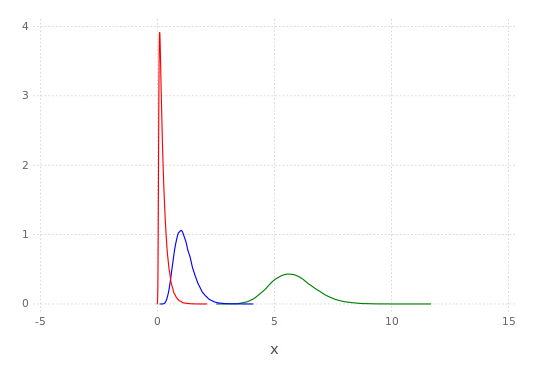

In [39]:
plot(layer(x=[rpolyagamma(1.0,1) for i = 1:1e5],Geom.density,Theme(default_color=colorant"red")),
layer(x=[rpolyagamma(1.0,5) for i = 1:1e5],Geom.density,Theme(default_color=colorant"blue")),
layer(x=[rpolyagamma(1.0,25) for i = 1:1e5],Geom.density,Theme(default_color=colorant"green")))

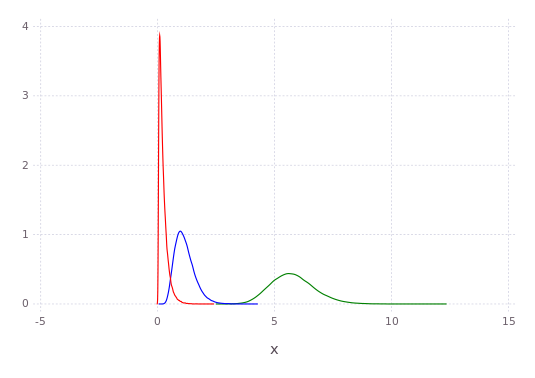

In [5]:
plot(layer(x=rcopy("rpg(1e5,z=1,h=1)"),Geom.density,Theme(default_color=colorant"red")),
layer(x=rcopy("rpg(1e5,z=1,h=5)"),Geom.density,Theme(default_color=colorant"blue")),
layer(x=rcopy("rpg(1e5,z=1,h=25)"),Geom.density,Theme(default_color=colorant"green")))

In [57]:
ApproximateTwoSampleKSTest([rpolyagamma(0.0) for i = 1:1e5],rcopy("rpg.devroye(1e5,z=0.0)"))

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0029800000000000013

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7662722532044661 (not significant)

Details:
    number of observations:   [100000,100000]
    KS-statistic:              0.6663482572949376


In [60]:
ApproximateTwoSampleKSTest([rpolyagamma(4.0) for i = 1:1e5],rcopy("rpg.devroye(1e5,z=4.0)"))

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0023799999999999984

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.9395703527118887 (not significant)

Details:
    number of observations:   [100000,100000]
    KS-statistic:              0.5321841786449496


Actually I will make one comment -- notice that my naive Julia implementation is twice as fast as their C++-via-R code!

In [44]:
@time for i = 1:1e6 rpolyagamma(1.0); end

  0.196080 seconds (476.00 k allocations: 7.263 MB, 1.05% gc time)


In [45]:
@time rcopy("rpg.devroye(1e6,z=1.0)");

  0.431118 seconds (3.00 M allocations: 99.183 MB, 1.54% gc time)
